In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_input
from tensorflow.keras.applications.xception import preprocess_input as xception_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image as image_method

In [14]:
with open("le_classes.pkl", "rb") as f:
    classes_fine = pickle.load(f)

In [15]:
classes_coarse = []

coarse_dict = {
    'automotive': ['Automobile,Comedy', 'Automobile'],
    'blog': ['Blog,Comedy', 'Blog,Entertainment', 'Blog', 'Blog,Science'],
    'comedy': ['Comedy', 'Comedy,Informative', 'Comedy,Entertainment'],
    'entertainment': ['Entertainment,Blog', 'Entertainment,Comedy', 'Entertainment'],
    'food': ['Food', 'Food,Entertainment'],
    'information': ['Science', 'News', 'Informative'],
    'technology': ['VideoGames', 'Tech,Comedy', 'Tech,News', 'Tech,Informative', 'Tech'],
}

for classs in classes:
    for key, value in coarse_dict.items():
        if classs in value:
            classes_coarse.append(key)

# Load Models

In [3]:
custom_v2 = load_model("./saved_models/v2/custom.h5")
inception_v2 = load_model("./saved_models/v2/inception_v3.h5")
resnet_v2 = load_model("./saved_models/v2/resnet_50.h5")
vgg_16_v2 = load_model("./saved_models/v2/vgg_16.h5")
xception_v2 = load_model("./saved_models/v2/xception.h5")

# Original Image

In [4]:
image_dirs = [
    "./data/images/NowThis News/t-lMIGV-dUI.jpg",
    "./data/images/Vox/t-osG0F2MZM.jpg",
    "./data/images/Fireship/ZtyMdRzvi0w.jpg",
    "./data/images/DramaAlert/-8tk0uk17gc.jpg",
    "./data/images/JRE Clips/VFns39RXPrU.jpg"
]

In [5]:
for layer in vgg_16_v2.layers:
    print(layer)

In [21]:
dataset = []

for image_dir in image_dirs:
    image = Image.open(image_dir)
    rgb_image = image.copy().convert("RGB")
    dataset.append(np.array(rgb_image.resize((224, 224)), dtype=np.uint8))

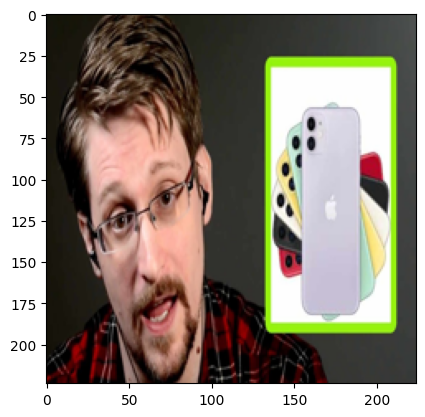

In [22]:
for image in dataset:
    plt.imshow(image)

# Grad Cam

In [17]:
def preprocess_img(img, model_name):
    # img = image.load_img(img_dir, target_size=(224, 224))
    img = image_method.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if model_name == 'vgg16':
        return vgg16_input(img)
    

def grad_cam(img_array, model, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        layer_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    gradients = tape.gradient(loss, layer_output)[0]
    casted_layer_output = tf.cast(layer_output > 0, "float32")
    casted_gradients = tf.cast(gradients > 0, "float32")
    guided_gradients = casted_layer_output * casted_gradients * gradients

    # Remove unnecessary dims
    layer_output = layer_output[0]

    weights = tf.reduce_mean(guided_gradients, axis=(0,1))
    grad_cam = tf.reduce_sum(tf.multiply(weights, layer_output), axis=-1)

    width, height = img_array.shape[2], img_array.shape[1]
    heatmap = cv2.resize(grad_cam.numpy(), (width, height))
    counter = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min())

    scaled_heatmap = counter / denominator
    
    return scaled_heatmap

def display_grad_cam(img, heatmap):
    img = image_method.img_to_array(img)
    heatmap = np.uint8(255*heatmap)
    
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image_method.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image_method.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = image_method.array_to_img(superimposed_img)
    
    return superimposed_img


In [19]:
img_array = preprocess_img(TO_ANALYZE_IMAGE, 'vgg16')
heatmap = grad_cam(img_array, vgg_16_v2, "vgg16")
plt.imshow(heatmap)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: []

In [ ]:
plt.imshow(display_grad_cam(img, heatmap))

# SHAP Values

Partition explainer: 2it [00:47, 47.05s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


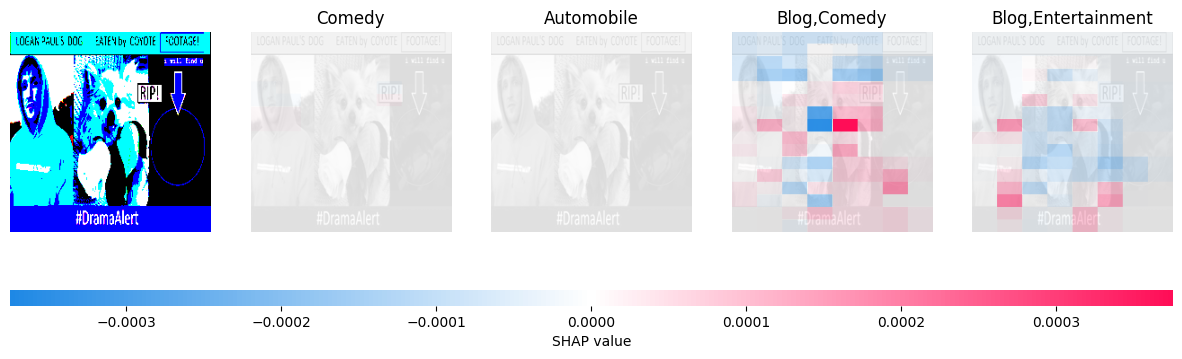

In [47]:
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

x = image.img_to_array(dataset[4])
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

masker = shap.maskers.Image("inpaint_telea", x.shape[1:])
explainer = shap.Explainer(xception_v2, masker, output_names=classes_fine, algorithm="partition")
shap_values = explainer(x, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values)

# Lime

In [13]:
import skimage
from lime import lime_image

img_arr = image.img_to_array(TO_ANALYZE_IMAGE)
img_processed = preprocess_input(img_arr)

lime_explainer = lime_image.LimeImageExplainer()
lime_explanation = lime_explainer.explain_instance(img_processed[0], vgg_16_v2.predict)

temp, mask = lime_explanation.get_image_and_mask(lime_explanation.top_labels[0], positive_only=False, hide_rest=False)
plt.figure(figsize=(3,3))
plt.imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask))


  1%|          | 9/1000 [00:00<00:11, 87.36it/s]


ValueError: in user code:

    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Dominik Hahn\anaconda3\envs\shap\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 224, 3, 3)
